In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train['outliers'] = np.where(df_train.target  <= -30, 1, 0)

In [4]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [7]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_categorical_rete__by__categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [8]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [9]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.895181	valid_1's auc: 0.87835
[200]	training's auc: 0.910783	valid_1's auc: 0.883653
[300]	training's auc: 0.924174	valid_1's auc: 0.888377
[400]	training's auc: 0.934325	valid_1's auc: 0.89034
[500]	training's auc: 0.943803	valid_1's auc: 0.891797
[600]	training's auc: 0.951934	valid_1's auc: 0.892423
[700]	training's auc: 0.959163	valid_1's auc: 0.892875
[800]	training's auc: 0.965412	valid_1's auc: 0.893204
[900]	training's auc: 0.970256	valid_1's auc: 0.893674
[1000]	training's auc: 0.974063	valid_1's auc: 0.89399
[1100]	training's auc: 0.977025	valid_1's auc: 0.894123
[1200]	training's auc: 0.979412	valid_1's auc: 0.894145
[1300]	training's auc: 0.981702	valid_1's auc: 0.894298
[1400]	training's auc: 0.983621	valid_1's auc: 0.894277
[1500]	training's auc: 0.985363	valid_1's auc: 0.894269
[1600]	training's auc: 0.986811	valid_1's auc: 0.894271
[1700]	training's auc: 0.988218	valid_1's auc:

0.8907002580111802

0.8805100268066539

In [39]:
rmse = []
for i in [i/1000.0 for i in range(1,1001)]:
    predict_outliers = np.where(oof>i, -33.21928095, 0)
    rmse.append(np.sqrt(mean_squared_error(target.values, predict_outliers)))
    if min(rmse) == rmse[-1]:
        print(i)
        print(rmse[-1])
        print("\n"*2)

0.001
27.676423489661182



0.002
23.86484847759361



0.003
21.8747102662274



0.004
20.468489837279463



0.005
19.285462854249268



0.006
18.259964572908753



0.007
17.324586687238547



0.008
16.501172410532707



0.009
15.75619304094203



0.01
15.089801793109496



0.011
14.499185433414159



0.012
13.96133908611569



0.013
13.492217159106845



0.014
13.071600517418766



0.015
12.68881985519923



0.016
12.325944632015034



0.017
11.99959178278278



0.018
11.712670533443443



0.019
11.445523419431018



0.02
11.186613139664933



0.021
10.959950272024171



0.022
10.736819019524065



0.023
10.520168112125253



0.024
10.31561723023885



0.025
10.127583800041002



0.026
9.925447739466266



0.027
9.750615096024239



0.028
9.571958385925843



0.029
9.408425025347725



0.03
9.251545010751236



0.031
9.087975055178527



0.032
8.936561269601016



0.033
8.802543466682815



0.034
8.661813797080374



0.035
8.535236139127433



0.036
8.411564032648887



0.037
8.281352

0.398
3.879017818938206



0.399
3.879017818938206



0.4
3.8783117572503314



0.406
3.8759697651138865



0.407
3.874219461841152



0.408
3.8735055453812275



0.409
3.8726386773874766



0.41
3.8726386773874766



0.413
3.871670458733481



0.414
3.8709708844396875



0.451
3.8703551797850557



0.454
3.870282413793198



0.455
3.870282413793198



0.456
3.8697062804184235



0.457
3.8697062804184235



0.458
3.8697062804184235



0.46
3.8696968809645154



0.461
3.8696968809645154



0.462
3.8690402679468203



0.463
3.8690402679468203



0.464
3.8690402679468203



0.479
3.8689970108615004



0.48
3.8681807361684957



0.481
3.8681807361684957



0.496
3.866851382503568



0.497
3.866851382503568



0.498
3.866851382503568



0.499
3.866851382503568



0.501
3.8666647625511885



0.502
3.8666647625511885





0.626<br>
3.869852853047011

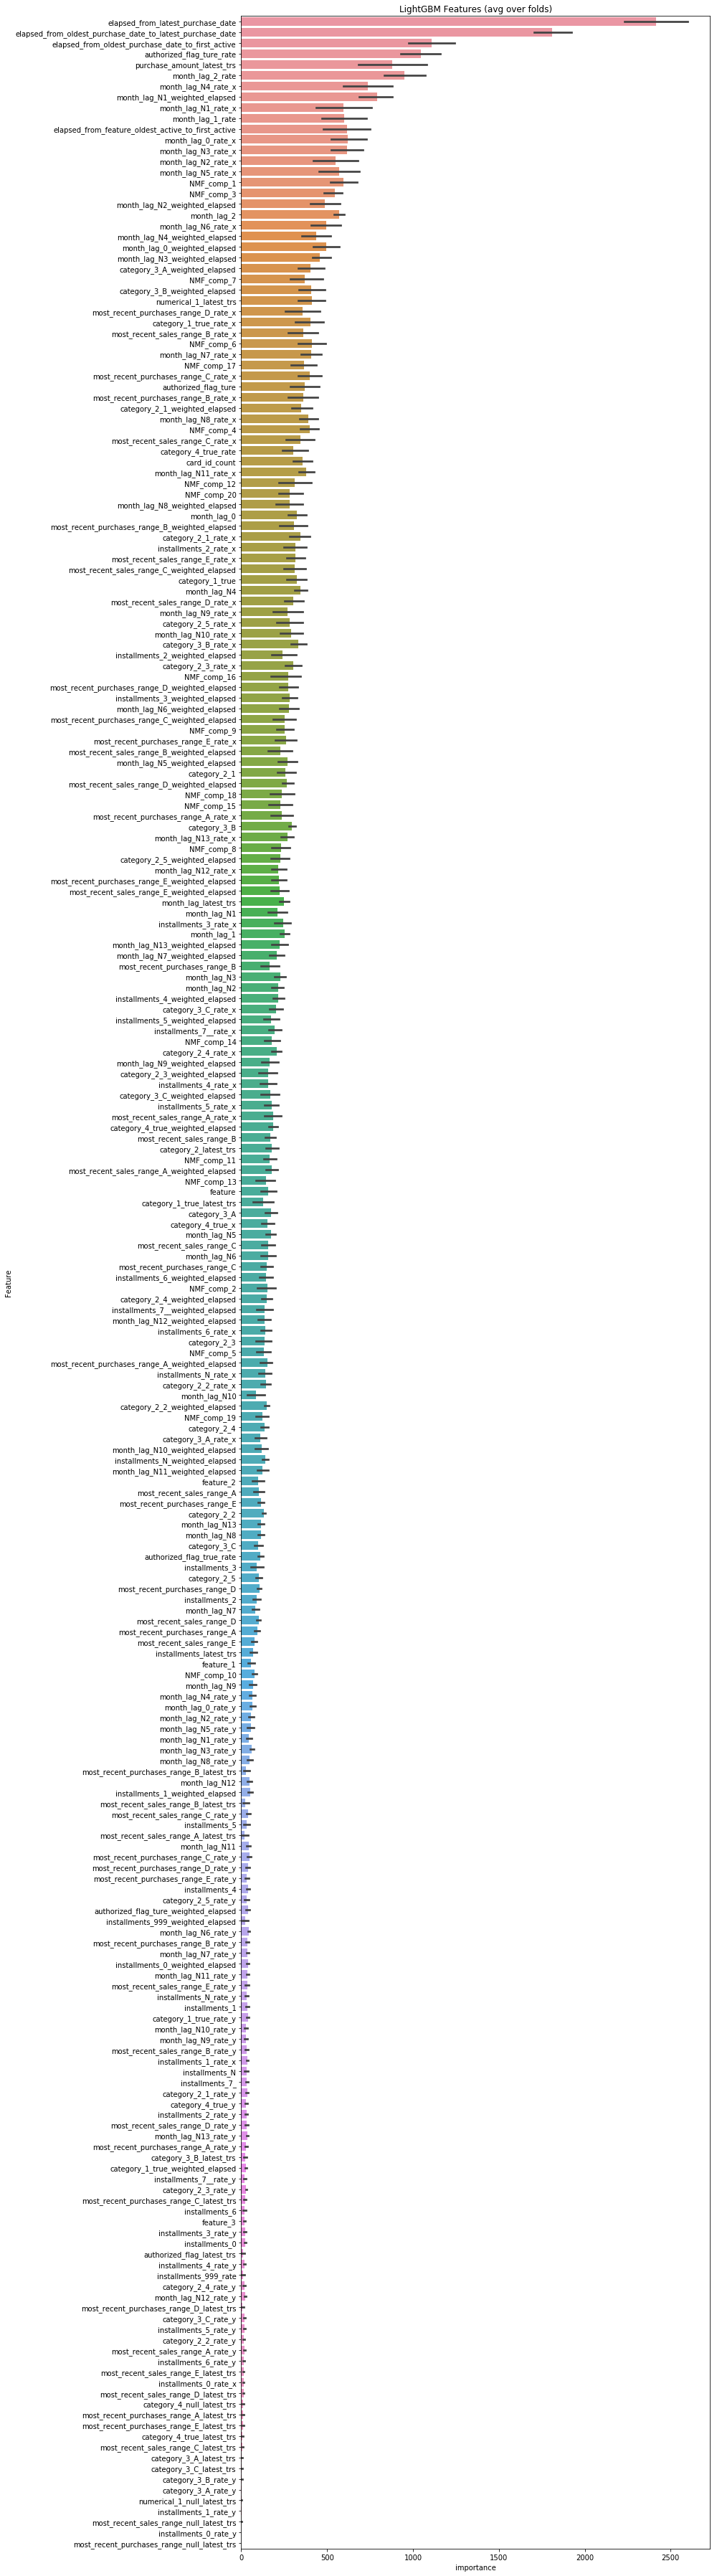

In [11]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [40]:
df_predict = pd.read_csv("../output/submission_model20181216.csv")

In [41]:
df_predict.shape

(123623, 2)

In [42]:
df_predict["outliers_prob"] = predictions

In [43]:
outliers_idx = df_predict[df_predict.outliers_prob > 0.502].index

In [44]:
np.min(df_train.target)

-33.21928095

In [45]:
df_predict["target"].iloc[outliers_idx] = -33.21928095

In [46]:
df_predict[df_predict.target < -30]

,card_id,target,outliers_prob
5008,C_ID_be92f84f5c,-33.219281,0.518701
26864,C_ID_e7c702e96f,-33.219281,0.504968
27436,C_ID_493de71141,-33.219281,0.530460
32446,C_ID_ac114ef831,-33.219281,0.582815
63978,C_ID_4cf141070f,-33.219281,0.519397
66362,C_ID_0bcfec9f5c,-33.219281,0.532629
78078,C_ID_922f9c5ea6,-33.219281,0.549869
91197,C_ID_7598b04bdf,-33.219281,0.589271
108079,C_ID_84e90acaf9,-33.219281,0.520292
116572,C_ID_f503a136f1,-33.219281,0.507963


In [38]:
df_predict[["card_id", "target"]].to_csv("../output/submission_model20181228.csv", index=False)